In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

### Basics

In [4]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')
    
    
def update_stocks_nc():
    os.system("rm mstncn.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/newconnect/mstock/mstncn.zip")
    #os.system("rm -rf data/*")
    os.system("unzip mstncn.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("CLOUD").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

### Do updates

In [5]:
update_indexes()

Updated 2020-04-29, max actual date:     2020-04-28


In [6]:
update_stocks()

Updated 2020-04-29, max actual date:     2020-04-29


In [7]:
update_stocks_nc()

Updated 2020-04-29, max actual date:     2020-04-29


In [8]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

no of all available stock: 2399 and indexes: 23


## Single plot

### Plot code

In [87]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [88]:
[a for a in all_stocks if 'INTROL' in a]

['INTROL.mst']

In [89]:
papier = 'INTROL'

In [90]:
#plot_paper(papier,'2008-07-15','2008-11-15')

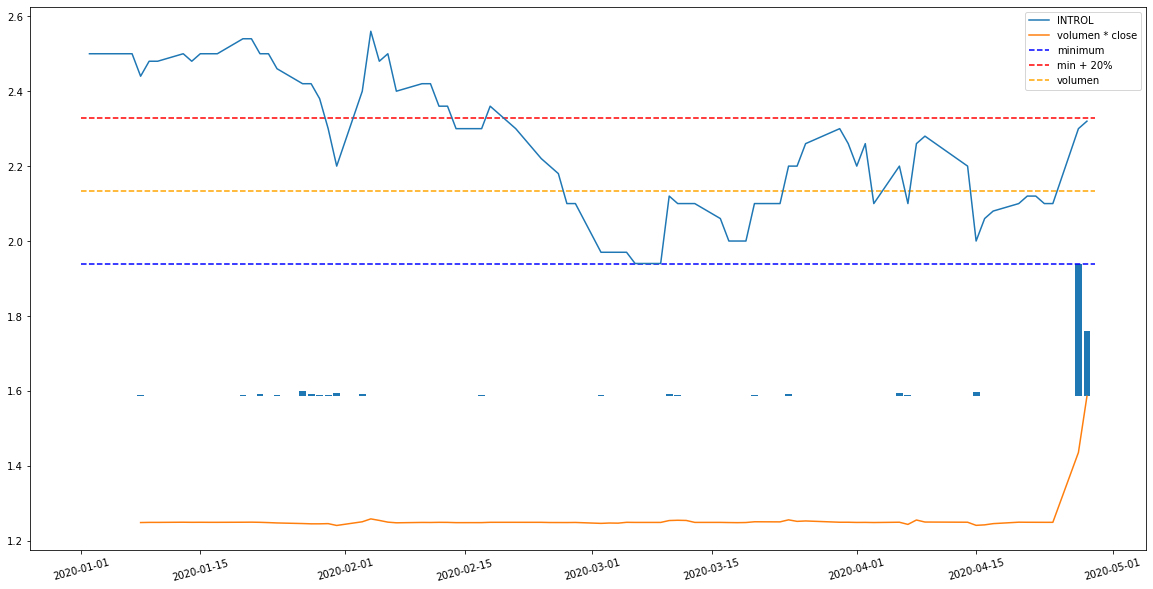

In [91]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [145]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [146]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: PLAY, currently at 33.8, with potential 12.43% to top
Max before crisis: 38.0
Crisis bottom: 25.94
Max after crisis drop: 33.8, at 2020-04-09 00:00:00
Stats after Max: [33.8]


## Skaner

In [9]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'mean_VOL', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [10]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index > '2019-10-01' ,'VOL'].mean(),
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 2399/2399 [00:15<00:00, 150.95it/s]


In [11]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [12]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        #(skaner_df.growth_current > -100)
    (skaner_df.mean_VOL > 10000)
                              ,:].sort_values('drop_current', ascending=True)

In [13]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('DVP' in x)
                               | ('RCT' in x)
                               | ('RCS' in x)
                               | ('RCR' in x)
                               | ('RCB' in x)
                               | ('PBSK' in x)
                               | ('RCL' in x) else True).values,]

In [14]:
skaner_df_see.dropna().shape

(251, 15)

In [15]:
skaner_df_see.dropna().head(100)

,ticker,current,mean_VOL,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,ITMTRADE,0.2280,2.179467e+04,1.270,2.2000,2.6000,0.2180,1.0900,2.2000,-42.27,-15.38,400.00,4.59,864.91,-89.64
0,ELBUDOWA,1.9500,1.035025e+05,7.680,6.2600,10.1000,1.2000,5.3000,9.2400,22.68,-38.02,341.67,62.50,373.85,-78.90
0,MABION,23.2500,3.404344e+04,51.100,80.0000,73.5000,17.9600,31.0000,103.6000,-36.12,8.84,72.61,29.45,345.59,-77.56
0,ALTUSTFI,0.6400,5.948789e+04,2.190,1.7200,2.1500,0.6400,1.2500,2.3000,27.33,-20.00,95.31,0.00,259.37,-72.17
0,BRASTER,0.3330,4.688440e+05,0.370,1.0400,1.7300,0.2000,0.4050,1.1620,-64.42,-39.88,102.50,66.50,248.95,-71.34
0,MOBIMEDIA,0.4000,1.672299e+05,0.725,0.4460,0.1290,0.2460,0.4000,1.2100,62.56,245.74,62.60,62.60,202.50,-66.94
0,SOLAR,3.5500,1.299997e+04,5.800,4.8800,5.1500,2.2000,3.6000,10.3000,18.85,-5.24,63.64,61.36,190.14,-65.53
0,CCC,46.5000,4.606560e+05,96.500,132.5000,153.9000,24.9800,47.0000,133.0000,-27.17,-13.91,88.15,86.15,186.02,-65.04
0,WORKSERV,0.4325,4.094649e+05,0.502,0.8600,2.2100,0.3420,0.4800,1.1440,-41.63,-61.09,40.35,26.46,164.51,-62.19
0,HERKULES,0.4720,1.770736e+04,0.860,1.1700,2.2200,0.4720,0.5900,1.2300,-26.50,-47.30,25.00,0.00,160.59,-61.63


## Model

In [16]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5, 10, 20, 30, 60, 120, 240]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###

    df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
    df.loc[df.loc[:, 'max_5d'].shift(-5) > df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 1
    df.loc[df.loc[:, 'max_5d'].shift(-5) <= df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 0
    
    return df
#ADD INDEX MEANS!
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
    for b in ['chng_OPEN', 'chng_LOW', 'chng_HIGH', 'chng_CLOSE', 'chng_VOL']:    
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'idxroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'idxroll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'idxroll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'idxroll{g}std_' + b] = df.loc[:,b].rolling(g).std()
    return df

In [17]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [18]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.dropna().ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

In [19]:
full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
#p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

 99%|█████████▉| 256/258 [02:57<00:01,  1.44it/s]


In [20]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

100%|█████████▉| 257/258 [00:10<00:00, 24.50it/s]


In [21]:
df_merged = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_merged = pd.concat([df_merged, df])
    pbar.update(1)
pbar.close()

100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


In [22]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

58

In [23]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:16<00:00,  1.42it/s]


In [24]:
df_indexes_merged = df_indexes_merged.reset_index().groupby('DTYYYYMMDD').mean()
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

idx_cols_chng = [c for c in df_indexes_merged.columns if 'chng' in c]

df_indexes_merged = df_indexes_merged.loc[:,idx_cols_chng]

df_indexes_merged = df_indexes_merged.dropna(how = 'all',axis = 1)

In [25]:
# df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
# df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
# df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

In [26]:
#df_merged = df_merged.drop([c for c in df_merged.columns if 'foreign_s' in c], axis = 1).copy()

In [27]:
df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [28]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

#train_cols = train_cols + list(df_indexes_merged.columns)

#train_cols = ['all_lower_cat', 'all_higher_cat'] + train_cols

In [44]:
train_cols = train_cols_limited

df = df_merged.copy()
#df = df.loc[df.index > '2007-01-01',:]

In [45]:
valid = df.loc[df.index >= '2020-03-01'].copy()

In [46]:
df = df.loc[df.index < '2020-03-01']

In [47]:
cut_date = '2019-11-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [48]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.05,
                           depth=3,
                          #thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')
    return model

In [49]:
model = get_model()

In [50]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          #eval_set=[(train_data[:-1], train_labels[:-1]),(eval_data[:-1], eval_labels[:-1])],
          eval_set=[(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=100, use_best_model=True)

0:	learn: 0.7253162	test: 0.7274025	best: 0.7274025 (0)	total: 13.6ms	remaining: 2m 15s
1:	learn: 0.7701434	test: 0.7615851	best: 0.7615851 (1)	total: 26.8ms	remaining: 2m 14s
2:	learn: 0.7753019	test: 0.7662243	best: 0.7662243 (2)	total: 38.9ms	remaining: 2m 9s
3:	learn: 0.7765675	test: 0.7670760	best: 0.7670760 (3)	total: 51ms	remaining: 2m 7s
4:	learn: 0.7781295	test: 0.7689155	best: 0.7689155 (4)	total: 63.8ms	remaining: 2m 7s
5:	learn: 0.7800232	test: 0.7707471	best: 0.7707471 (5)	total: 77.2ms	remaining: 2m 8s
6:	learn: 0.7804233	test: 0.7711492	best: 0.7711492 (6)	total: 90ms	remaining: 2m 8s
7:	learn: 0.7839236	test: 0.7743931	best: 0.7743931 (7)	total: 102ms	remaining: 2m 7s
8:	learn: 0.7840365	test: 0.7743711	best: 0.7743931 (7)	total: 114ms	remaining: 2m 7s
9:	learn: 0.7842193	test: 0.7747643	best: 0.7747643 (9)	total: 127ms	remaining: 2m 6s
10:	learn: 0.7848894	test: 0.7749344	best: 0.7749344 (10)	total: 139ms	remaining: 2m 5s
11:	learn: 0.7854760	test: 0.7752762	best: 0.77

104:	learn: 0.7996476	test: 0.7829312	best: 0.7829393 (101)	total: 1.24s	remaining: 1m 57s
105:	learn: 0.7996920	test: 0.7828692	best: 0.7829393 (101)	total: 1.26s	remaining: 1m 57s
106:	learn: 0.7997925	test: 0.7828906	best: 0.7829393 (101)	total: 1.27s	remaining: 1m 57s
107:	learn: 0.7998273	test: 0.7828856	best: 0.7829393 (101)	total: 1.28s	remaining: 1m 57s
108:	learn: 0.7998995	test: 0.7828808	best: 0.7829393 (101)	total: 1.29s	remaining: 1m 57s
109:	learn: 0.7999434	test: 0.7830007	best: 0.7830007 (109)	total: 1.3s	remaining: 1m 57s
110:	learn: 0.8000243	test: 0.7830027	best: 0.7830027 (110)	total: 1.31s	remaining: 1m 56s
111:	learn: 0.8001044	test: 0.7830027	best: 0.7830027 (110)	total: 1.32s	remaining: 1m 56s
112:	learn: 0.8001843	test: 0.7831963	best: 0.7831963 (112)	total: 1.33s	remaining: 1m 56s
113:	learn: 0.8001951	test: 0.7832091	best: 0.7832091 (113)	total: 1.34s	remaining: 1m 56s
114:	learn: 0.8002375	test: 0.7833063	best: 0.7833063 (114)	total: 1.36s	remaining: 1m 56s


197:	learn: 0.8035920	test: 0.7847169	best: 0.7847329 (195)	total: 2.26s	remaining: 1m 51s
198:	learn: 0.8036199	test: 0.7846757	best: 0.7847329 (195)	total: 2.27s	remaining: 1m 51s
199:	learn: 0.8036559	test: 0.7846734	best: 0.7847329 (195)	total: 2.28s	remaining: 1m 51s
200:	learn: 0.8036861	test: 0.7846492	best: 0.7847329 (195)	total: 2.29s	remaining: 1m 51s
201:	learn: 0.8037102	test: 0.7847725	best: 0.7847725 (201)	total: 2.31s	remaining: 1m 51s
202:	learn: 0.8037501	test: 0.7849089	best: 0.7849089 (202)	total: 2.32s	remaining: 1m 51s
203:	learn: 0.8037783	test: 0.7849692	best: 0.7849692 (203)	total: 2.33s	remaining: 1m 51s
204:	learn: 0.8037884	test: 0.7849546	best: 0.7849692 (203)	total: 2.34s	remaining: 1m 51s
205:	learn: 0.8038184	test: 0.7849697	best: 0.7849697 (205)	total: 2.35s	remaining: 1m 51s
206:	learn: 0.8038574	test: 0.7850036	best: 0.7850036 (206)	total: 2.36s	remaining: 1m 51s
207:	learn: 0.8038717	test: 0.7850255	best: 0.7850255 (207)	total: 2.37s	remaining: 1m 51s

291:	learn: 0.8061981	test: 0.7862108	best: 0.7862195 (290)	total: 3.28s	remaining: 1m 49s
292:	learn: 0.8062633	test: 0.7862334	best: 0.7862334 (292)	total: 3.29s	remaining: 1m 49s
293:	learn: 0.8062747	test: 0.7862215	best: 0.7862334 (292)	total: 3.31s	remaining: 1m 49s
294:	learn: 0.8063155	test: 0.7862149	best: 0.7862334 (292)	total: 3.32s	remaining: 1m 49s
295:	learn: 0.8063330	test: 0.7862049	best: 0.7862334 (292)	total: 3.33s	remaining: 1m 49s
296:	learn: 0.8063438	test: 0.7862378	best: 0.7862378 (296)	total: 3.34s	remaining: 1m 49s
297:	learn: 0.8063515	test: 0.7862254	best: 0.7862378 (296)	total: 3.35s	remaining: 1m 49s
298:	learn: 0.8063722	test: 0.7862128	best: 0.7862378 (296)	total: 3.36s	remaining: 1m 49s
299:	learn: 0.8063904	test: 0.7862141	best: 0.7862378 (296)	total: 3.37s	remaining: 1m 48s
300:	learn: 0.8064070	test: 0.7862199	best: 0.7862378 (296)	total: 3.38s	remaining: 1m 48s
301:	learn: 0.8064222	test: 0.7862286	best: 0.7862378 (296)	total: 3.39s	remaining: 1m 48s

382:	learn: 0.8080910	test: 0.7862825	best: 0.7863422 (326)	total: 4.29s	remaining: 1m 47s
383:	learn: 0.8081101	test: 0.7862846	best: 0.7863422 (326)	total: 4.31s	remaining: 1m 47s
384:	learn: 0.8081654	test: 0.7862846	best: 0.7863422 (326)	total: 4.32s	remaining: 1m 47s
385:	learn: 0.8081824	test: 0.7862597	best: 0.7863422 (326)	total: 4.33s	remaining: 1m 47s
386:	learn: 0.8081955	test: 0.7862312	best: 0.7863422 (326)	total: 4.35s	remaining: 1m 47s
387:	learn: 0.8082042	test: 0.7862638	best: 0.7863422 (326)	total: 4.36s	remaining: 1m 47s
388:	learn: 0.8082175	test: 0.7862375	best: 0.7863422 (326)	total: 4.37s	remaining: 1m 47s
389:	learn: 0.8082433	test: 0.7862141	best: 0.7863422 (326)	total: 4.38s	remaining: 1m 47s
390:	learn: 0.8082659	test: 0.7862180	best: 0.7863422 (326)	total: 4.39s	remaining: 1m 47s
391:	learn: 0.8082936	test: 0.7862054	best: 0.7863422 (326)	total: 4.4s	remaining: 1m 47s
392:	learn: 0.8083657	test: 0.7861737	best: 0.7863422 (326)	total: 4.41s	remaining: 1m 47s


478:	learn: 0.8101005	test: 0.7864408	best: 0.7864722 (477)	total: 5.51s	remaining: 1m 49s
479:	learn: 0.8101174	test: 0.7864120	best: 0.7864722 (477)	total: 5.53s	remaining: 1m 49s
480:	learn: 0.8101200	test: 0.7864124	best: 0.7864722 (477)	total: 5.54s	remaining: 1m 49s
481:	learn: 0.8101349	test: 0.7864248	best: 0.7864722 (477)	total: 5.55s	remaining: 1m 49s
482:	learn: 0.8101434	test: 0.7864170	best: 0.7864722 (477)	total: 5.56s	remaining: 1m 49s
483:	learn: 0.8101451	test: 0.7864170	best: 0.7864722 (477)	total: 5.57s	remaining: 1m 49s
484:	learn: 0.8101687	test: 0.7864172	best: 0.7864722 (477)	total: 5.58s	remaining: 1m 49s
485:	learn: 0.8101739	test: 0.7864138	best: 0.7864722 (477)	total: 5.6s	remaining: 1m 49s
486:	learn: 0.8101766	test: 0.7864206	best: 0.7864722 (477)	total: 5.61s	remaining: 1m 49s
487:	learn: 0.8101883	test: 0.7864308	best: 0.7864722 (477)	total: 5.62s	remaining: 1m 49s
488:	learn: 0.8101932	test: 0.7864419	best: 0.7864722 (477)	total: 5.63s	remaining: 1m 49s


571:	learn: 0.8116997	test: 0.7868225	best: 0.7868319 (567)	total: 6.54s	remaining: 1m 47s
572:	learn: 0.8117168	test: 0.7868585	best: 0.7868585 (572)	total: 6.55s	remaining: 1m 47s
573:	learn: 0.8117292	test: 0.7868612	best: 0.7868612 (573)	total: 6.56s	remaining: 1m 47s
574:	learn: 0.8117691	test: 0.7868597	best: 0.7868612 (573)	total: 6.57s	remaining: 1m 47s
575:	learn: 0.8117784	test: 0.7868544	best: 0.7868612 (573)	total: 6.58s	remaining: 1m 47s
576:	learn: 0.8117852	test: 0.7868652	best: 0.7868652 (576)	total: 6.59s	remaining: 1m 47s
577:	learn: 0.8117977	test: 0.7868819	best: 0.7868819 (577)	total: 6.6s	remaining: 1m 47s
578:	learn: 0.8118113	test: 0.7868900	best: 0.7868900 (578)	total: 6.61s	remaining: 1m 47s
579:	learn: 0.8118222	test: 0.7868660	best: 0.7868900 (578)	total: 6.63s	remaining: 1m 47s
580:	learn: 0.8118803	test: 0.7868388	best: 0.7868900 (578)	total: 6.64s	remaining: 1m 47s
581:	learn: 0.8118803	test: 0.7868313	best: 0.7868900 (578)	total: 6.65s	remaining: 1m 47s


664:	learn: 0.8131279	test: 0.7870996	best: 0.7871906 (661)	total: 7.57s	remaining: 1m 46s
665:	learn: 0.8131435	test: 0.7870839	best: 0.7871906 (661)	total: 7.58s	remaining: 1m 46s
666:	learn: 0.8131574	test: 0.7870954	best: 0.7871906 (661)	total: 7.59s	remaining: 1m 46s
667:	learn: 0.8131651	test: 0.7870920	best: 0.7871906 (661)	total: 7.6s	remaining: 1m 46s
668:	learn: 0.8131751	test: 0.7870966	best: 0.7871906 (661)	total: 7.61s	remaining: 1m 46s
669:	learn: 0.8131887	test: 0.7870961	best: 0.7871906 (661)	total: 7.62s	remaining: 1m 46s
670:	learn: 0.8132043	test: 0.7871160	best: 0.7871906 (661)	total: 7.63s	remaining: 1m 46s
671:	learn: 0.8132294	test: 0.7871078	best: 0.7871906 (661)	total: 7.64s	remaining: 1m 46s
672:	learn: 0.8132413	test: 0.7871194	best: 0.7871906 (661)	total: 7.65s	remaining: 1m 46s
673:	learn: 0.8132788	test: 0.7871052	best: 0.7871906 (661)	total: 7.66s	remaining: 1m 46s
674:	learn: 0.8132969	test: 0.7871028	best: 0.7871906 (661)	total: 7.67s	remaining: 1m 46s


756:	learn: 0.8144088	test: 0.7869779	best: 0.7872192 (688)	total: 8.59s	remaining: 1m 44s
757:	learn: 0.8144116	test: 0.7869643	best: 0.7872192 (688)	total: 8.61s	remaining: 1m 44s
758:	learn: 0.8144206	test: 0.7869543	best: 0.7872192 (688)	total: 8.62s	remaining: 1m 44s
759:	learn: 0.8144304	test: 0.7869387	best: 0.7872192 (688)	total: 8.63s	remaining: 1m 44s
760:	learn: 0.8144413	test: 0.7869379	best: 0.7872192 (688)	total: 8.64s	remaining: 1m 44s
761:	learn: 0.8144920	test: 0.7869351	best: 0.7872192 (688)	total: 8.65s	remaining: 1m 44s
762:	learn: 0.8145023	test: 0.7869320	best: 0.7872192 (688)	total: 8.66s	remaining: 1m 44s
763:	learn: 0.8145259	test: 0.7869217	best: 0.7872192 (688)	total: 8.67s	remaining: 1m 44s
764:	learn: 0.8145400	test: 0.7869368	best: 0.7872192 (688)	total: 8.68s	remaining: 1m 44s
765:	learn: 0.8145513	test: 0.7869330	best: 0.7872192 (688)	total: 8.7s	remaining: 1m 44s
766:	learn: 0.8145601	test: 0.7869354	best: 0.7872192 (688)	total: 8.71s	remaining: 1m 44s


In [51]:
model.get_feature_importance(prettified=True).head(50)

,Feature Id,Importances
0,roll240std_chng_HIGH,9.863214
1,roll120std_chng_HIGH,5.685310
2,roll80std_chng_OPEN,5.230609
3,roll40std_chng_HIGH,4.850775
4,roll240max_chng_HIGH,3.907641
5,roll40std_chng_OPEN,2.980908
6,roll240std_chng_CLOSE,2.816747
7,roll240std_chng_OPEN,2.546831
8,roll120std_diff_LOW_CLOSE,2.060449
9,roll120std_diff_HIGH_CLOSE,1.940869


In [52]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

37

### Check performance

In [53]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [58]:
preds = preds_proba[:,1].copy()

preds[preds > 0.6] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [59]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[16257,     7],
       [ 2180,    30]])

In [60]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(16257, 7, 2180, 30)

In [61]:
(tn + tp) / (tn + tp + fp + fn)

0.8816174082494317

In [62]:
tp / (tp + fp)

0.8108108108108109

In [63]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.899297,0.100703
1.0,0.768733,0.231267


In [64]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)
df_res_grouped = df_res.drop('zero', axis = 1)

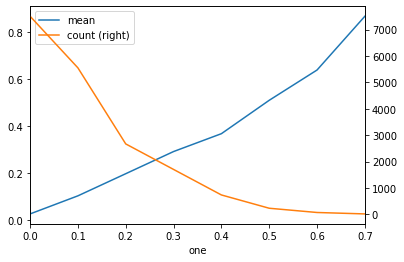

In [65]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [66]:
df_res_grouped

,mean,count
one,,
0.0,0.024777,7507
0.1,0.101783,5551
0.2,0.196027,2668
0.3,0.290417,1701
0.4,0.366485,734
0.5,0.508696,230
0.6,0.637681,69
0.7,0.866667,15


#### Check valid

In [67]:
valid_data = valid.loc[:,train_cols]
valid_labels = valid.loc[:,'target'].values

preds_class = model.predict(valid_data)
# Get predicted probabilities for each class

preds = preds_class[:-1].astype(int)

In [94]:
preds_proba = model.predict_proba(valid_data)

preds = preds_proba[:,1].copy()

preds[preds > 0.58] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [95]:
confusion_matrix(valid_labels[:-1].astype(int), preds)

array([[6468,   40],
       [2040,   83]])

In [96]:
tn, fp, fn, tp = confusion_matrix(valid_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(6468, 40, 2040, 83)

In [97]:
(tn + tp) / (tn + tp + fp + fn)

0.7590082261615109

In [98]:
tp / (tp + fp)

0.6747967479674797

### Prediction

In [84]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes_merged,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fut5_CLOSE'] = df.loc[:, 'CLOSE'].shift(-5)
        df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
        
        df.loc[:, 'fut10_CLOSE'] = df.loc[:, 'CLOSE'].shift(-10)
        df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
        
        df.loc[:, 'fOPEN_f10CLOSE_chng'] = (df.loc[:, 'fut10_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f10MAX_chng'] = (df.loc[:, 'max_10d'].shift(-10) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5CLOSE_chng'] = (df.loc[:, 'fut5_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5MAX_chng'] = (df.loc[:, 'max_5d'].shift(-5) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE', 'fOPEN_fHIGH_chng', 
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 
            'fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng',
            'fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng', 'pred_prob']
                                      ].tail(30)
    
        #if one_res.shape == (15, 16):
        qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [85]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

In [86]:
total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
#p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


pbar = tqdm(total = total)

while not qpapers.empty():
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()

 98%|█████████▊| 247/251 [03:26<00:03,  1.20it/s]


In [87]:
qtransformed.qsize()

251

In [88]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)

100%|██████████| 251/251 [00:00<00:00, 943.02it/s]


In [89]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

### Prediction results

In [90]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [91]:
res.loc[res.DTYYYYMMDD == '2020-04-20'].sort_values('pred_prob', ascending=False).tail(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fHIGH_chng,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,fOPEN_f5CLOSE_chng,fOPEN_f5MAX_chng,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng,pred_prob
1528,2020-04-20,GENRG,0.5500,0.524,0.5600,0.5440,0.5500,0.485,0.550,0.5260,0.000000e+00,-4.363636,1.102941e+00,-1.785714,-7.442748,-8.363636,-4.363636,NaN,NaN,0.179979
1499,2020-04-20,LIVECHAT,55.0000,52.400,55.0000,53.5000,54.2000,51.800,54.200,53.8000,0.000000e+00,-0.738007,1.308411e+00,-1.454545,-1.145038,2.214022,2.214022,NaN,NaN,0.179333
4722,2020-04-20,GETIN,0.9545,0.934,0.9545,0.9355,0.9405,0.900,0.943,0.9195,2.658161e-01,-2.232855,5.344735e-01,-1.204819,-3.640257,-1.169591,-1.116427,NaN,NaN,0.178186
1813,2020-04-20,TOYA,4.9600,4.860,4.9900,4.9000,4.9000,4.500,4.900,4.5300,0.000000e+00,-7.551020,0.000000e+00,-1.803607,-7.407407,-7.551020,-3.265306,NaN,NaN,0.177798
535,2020-04-20,MARVIPOL,3.6000,3.500,3.7500,3.7000,3.7500,3.430,3.750,3.4500,0.000000e+00,-8.000000,1.351351e+00,0.000000,-2.000000,-0.266667,-0.266667,NaN,NaN,0.176367
1775,2020-04-20,BRASTER,0.3800,0.370,0.3800,0.3780,0.3780,0.341,0.378,0.3550,-1.421085e-14,-6.084656,-1.421085e-14,-0.526316,-7.837838,-6.878307,1.058201,NaN,NaN,0.176155
3089,2020-04-20,CIGAMES,0.7570,0.699,0.7570,0.7200,0.7100,0.640,0.710,0.6620,0.000000e+00,-6.760563,-1.388889e+00,-6.208719,-8.440629,0.140845,0.140845,NaN,NaN,0.175876
3762,2020-04-20,BIOTON,4.2000,4.005,4.2400,4.0600,4.0050,3.760,4.010,3.9200,1.248439e-01,-2.122347,-1.354680e+00,-5.424528,-6.117353,-3.620474,0.624220,NaN,NaN,0.175518
1400,2020-04-20,TORPOL,7.7800,7.620,7.9600,7.7400,7.6600,7.040,7.660,7.3400,0.000000e+00,-4.177546,-1.033592e+00,-3.768844,-7.611549,0.000000,0.522193,NaN,NaN,0.174488
1235,2020-04-20,WIRTUALNA,68.0000,67.000,72.0000,70.2000,69.6000,67.000,73.600,71.0000,5.747126e+00,2.011494,-8.547009e-01,2.222222,0.000000,-9.482759,2.298851,NaN,NaN,0.172693


In [93]:
res.loc[res.DTYYYYMMDD == '2020-04-29'].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fHIGH_chng,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,fOPEN_f5CLOSE_chng,fOPEN_f5MAX_chng,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng,pred_prob
1782,2020-04-29,ITMTRADE,0.190,0.1900,0.239,0.2280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589820
1542,2020-04-29,NFPL,0.222,0.2051,0.240,0.2051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.564383
848,2020-04-29,JWA,0.210,0.2000,0.220,0.2150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.561708
1151,2020-04-29,IGORIA,0.163,0.1410,0.187,0.1870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.492204
1732,2020-04-29,AITON,0.350,0.3300,0.350,0.3500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.452750
1490,2020-04-29,MERLINGRP,0.300,0.3000,0.310,0.3100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.413052
1357,2020-04-29,PARCELTEC,0.890,0.7120,0.980,0.7120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.412503
3189,2020-04-29,KOMPUTRON,2.050,1.9100,2.160,2.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.395679
5925,2020-04-29,ELBUDOWA,1.992,1.9000,2.045,1.9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384017
1400,2020-04-29,FABRYKAKD,0.106,0.1060,0.127,0.1270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363411


In [99]:
last_day = res.loc[res.DTYYYYMMDD == '2020-04-28'].sort_values('pred_prob', ascending=False)

In [100]:
#res.TICKER.apply(lambda x: True if 'INTROL' in x else False).sum()

In [101]:
last_day.mean()

OPEN                   849.608922
LOW                    843.313429
HIGH                   859.788148
CLOSE                  848.889667
fut_OPEN               873.879131
fut_LOW                869.564100
fut_HIGH               893.948975
fut_CLOSE              890.529872
fOPEN_fHIGH_chng         4.135661
fOPEN_fCLOSE_chng        1.698743
CLOSE_fOPEN_chng         0.565024
HIGH_fHIGH_chng          1.189896
LOW_fLOW_chng            0.757448
fOPEN_f5CLOSE_chng            NaN
fOPEN_f5MAX_chng              NaN
fOPEN_f10CLOSE_chng           NaN
fOPEN_f10MAX_chng             NaN
pred_prob                0.145324
dtype: float64

In [103]:
last_day.loc[last_day.pred_prob > 0.4].mean()

OPEN                    0.202333
LOW                     0.187000
HIGH                    0.222333
CLOSE                   0.205333
fut_OPEN                0.187667
fut_LOW                 0.177000
fut_HIGH                0.215333
fut_CLOSE               0.210000
fOPEN_fHIGH_chng       15.091768
fOPEN_fCLOSE_chng      12.368293
CLOSE_fOPEN_chng       -8.285474
HIGH_fHIGH_chng        -2.988991
LOW_fLOW_chng          -5.782546
fOPEN_f5CLOSE_chng           NaN
fOPEN_f5MAX_chng             NaN
fOPEN_f10CLOSE_chng          NaN
fOPEN_f10MAX_chng            NaN
pred_prob               0.457870
dtype: float64

In [104]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                    0.971457
LOW                     0.863073
HIGH                    1.007695
CLOSE                   0.895499
fut_OPEN                0.931994
fut_LOW                 0.884324
fut_HIGH                1.021575
fut_CLOSE               0.953153
fOPEN_fHIGH_chng        7.732249
fOPEN_fCLOSE_chng       4.948149
CLOSE_fOPEN_chng        0.141431
HIGH_fHIGH_chng         0.570030
LOW_fLOW_chng           1.771719
fOPEN_f5CLOSE_chng     20.179991
fOPEN_f5MAX_chng       31.790949
fOPEN_f10CLOSE_chng    40.149455
fOPEN_f10MAX_chng      64.200138
pred_prob               0.563024
dtype: float64

In [105]:
res_see.loc[:,'pred_prob_rounded'] = res_see.pred_prob.round(1)

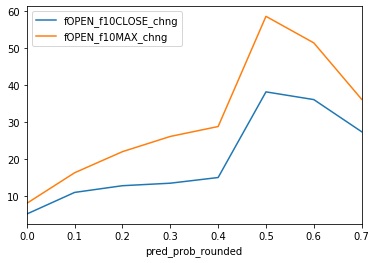

In [106]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng']].plot()

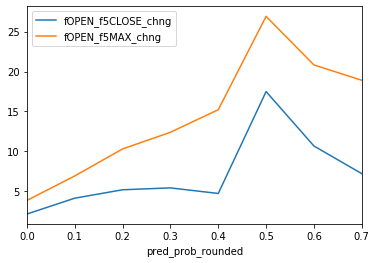

In [107]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng']].plot()

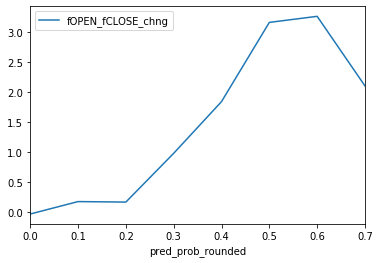

In [109]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_fCLOSE_chng']].plot()

## Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
